# This notebook will showcase what is the default pipeline for data correction.

The notebook is awfully similar to the previous one. In fact, it is mostly a shortened version of notebook 01. The point is that wile notebook 01 is more about showing all sorts of functions in detail and letting you play with them, this one is about showing relatively concisely all steps of the standard processing. Also, here we skip explanations of parameters etc.

### Import modules

In [1]:
# For I/O
import os
import sys

# For localizing FCSArtifactFixer
repo_dir = os.path.abspath('..')

# For data processing
sys.path.insert(0, repo_dir)
import tttrlib
from functions import FCSArtifactFixer
import numpy as np

# Other
import matplotlib.pyplot as plt # Plotting
import datetime # Time tagging
import warnings # Suppressing warnings in plotting

### Specify and import data

In [2]:
in_dir = '../test_data/'
in_file = '4ch_setup_membr_assoc_prot_A655.ptu'

# Define full input and output paths. 
# We add a time tag to the ouput path to avoid overwriting when experimenting with settings
in_path = os.path.join(in_dir, in_file)
out_path = os.path.join(in_dir, datetime.datetime.now().strftime("%Y%m%d_%H%M") +'_'+ os.path.splitext(in_file)[0])

# Import raw data as tttrlib.TTTR object
photon_data = tttrlib.TTTR(in_path,'PTU')

# Print something from TTTR object, just to confirm that we had a meaningful import
print(f'Imported {len(photon_data)} photons in routing channels {np.unique(photon_data.routing_channels)}.')

Imported 3814275 photons in routing channels [0 1 2 3 4 5].


### Create FCSArtifactFixer instance and define global settings

In [3]:
# Settings

tau_min = 1E-6 
tau_max = 1.0 
sampling = 6 
cross_corr_symm = True 
correlation_method = 'default'
subtract_afterpulsing = False
afterpulsing_params_path = 'ap_params_2ch_setup.csv' # relative path assuming it is in same dir as notebook

script_name = 'Jupyter Notebook 01_Overview'

fixer = FCSArtifactFixer.FCSArtifactFixer(photon_data = photon_data, 
                                            out_path = os.path.abspath(out_path),
                                            tau_min = tau_min,
                                            tau_max = tau_max,
                                            sampling = sampling,
                                            cross_corr_symm = cross_corr_symm,
                                            correlation_method = correlation_method,
                                            subtract_afterpulsing = subtract_afterpulsing,
                                            afterpulsing_params_path = afterpulsing_params_path,
                                            weights_ext = None,
                                            write_results = True,
                                            include_header = True,
                                            write_log = True)
print(fixer.out_path)

/fs/gpfs41/lv02/fileset02/pool/pool-schwille-spt/_Software/FCS_cleaner_dev/FCSArtifactFixer/test_data/20230920_1751_4ch_setup_membr_assoc_prot_A655


### Specify channels and micro time gates

In [4]:
channels_spec_1 = ((1,), ((0.5,), (1,)))
channels_spec_2 = ((2,), ((0.5,), (1,)))

print(f'Normalized channels_spec_1: {fixer.check_channels_spec(channels_spec_1)}')
print(f'Normalized channels_spec_2: {fixer.check_channels_spec(channels_spec_2)}')

Normalized channels_spec_1: ((1,), ((0.5,), (1,)))
Normalized channels_spec_2: ((2,), ((0.5,), (1,)))


### Correlate without corrections

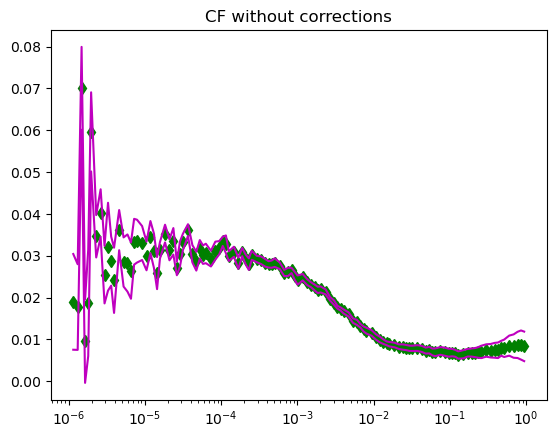

In [5]:
default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10

lags, cc, sd_cc, acr1, acr2 = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                channels_spec_2, 
                                                                default_uncertainty_method = default_uncertainty_method,
                                                                minimum_window_length = minimum_window_length,
                                                                n_bootstrap_reps = n_bootstrap_reps,
                                                                tau_min = None,
                                                                tau_max = None,
                                                                use_ext_weights = False, 
                                                                use_drift_correction = False,
                                                                use_flcs_bg_corr = False,
                                                                use_burst_removal = False,
                                                                use_mse_filter = False,
                                                                suppress_logging = False,
                                                                calling_function = script_name)


# PLot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags*1E-9, cc, 'dg')
ax.semilogx(lags*1E-9, cc+sd_cc, '-m')
ax.semilogx(lags*1E-9, cc-sd_cc, '-m')

ax.set_title('CF without corrections')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Artifact fix 1: Burst removal, step1: Construct time trace(s)

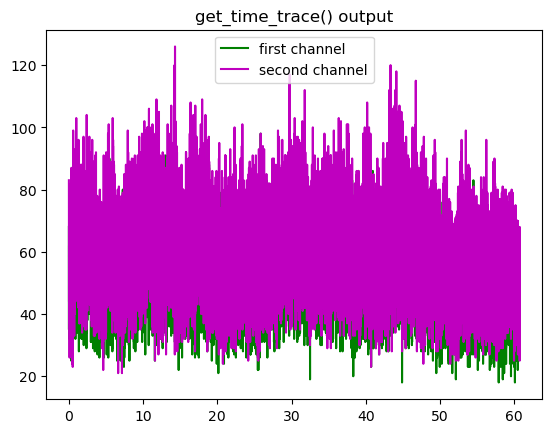

In [6]:
min_avg_counts = 10.
min_bin_width = 1E-4
use_tau_diff = True

time_trace_sampling = fixer.get_trace_time_scale(channels_spec_1,
                                                 min_avg_counts = min_avg_counts,
                                                 min_bin_width = min_bin_width,
                                                 use_tau_diff = use_tau_diff,
                                                 ext_indices = np.array([]),
                                                 use_ext_weights = False,
                                                 use_drift_correction = False,
                                                 use_flcs_bg_corr = False,
                                                 use_burst_removal = False,
                                                 use_mse_filter = False,
                                                 suppress_logging = False,
                                                 calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    # If we have two-channel data, let's use a geometric mean of 
    # time_trace_sampling suggestions for two the two channels as compromise
    time_trace_sampling = np.sqrt(time_trace_sampling * fixer.get_trace_time_scale(channels_spec_2,
                                                                                   min_avg_counts = min_avg_counts,
                                                                                   min_bin_width = min_bin_width,
                                                                                   use_tau_diff = use_tau_diff,
                                                                                   ext_indices = np.array([]),
                                                                                   use_ext_weights = False,
                                                                                   use_drift_correction = False,
                                                                                   use_flcs_bg_corr = False,
                                                                                   use_burst_removal = False,
                                                                                   use_mse_filter = False,
                                                                                   suppress_logging = False,
                                                                                   calling_function = script_name))

time_trace_counts_1, time_trace_t_1 = fixer.get_time_trace(channels_spec_1,
                                                           time_trace_sampling,
                                                           ext_indices = np.array([]),
                                                           use_ext_weights = False,
                                                           use_drift_correction = False,
                                                           use_flcs_bg_corr = False,
                                                           use_burst_removal = False,
                                                           use_mse_filter = False,
                                                           suppress_logging = False,
                                                           calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    time_trace_counts_2, time_trace_t_2 = fixer.get_time_trace(channels_spec_2,
                                                               time_trace_sampling,
                                                               ext_indices = np.array([]),
                                                               use_ext_weights = False,
                                                               use_drift_correction = False,
                                                               use_flcs_bg_corr = False,
                                                               use_burst_removal = False,
                                                               use_mse_filter = False,
                                                               suppress_logging = False,
                                                               calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time_trace_t_1, time_trace_counts_1, 'g', label = 'first channel')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    ax.plot(time_trace_t_2, time_trace_counts_2, 'm', label = 'second channel')
    ax.legend()
    
ax.set_title('get_time_trace() output')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Continuing burst removal: Actually remove bursts

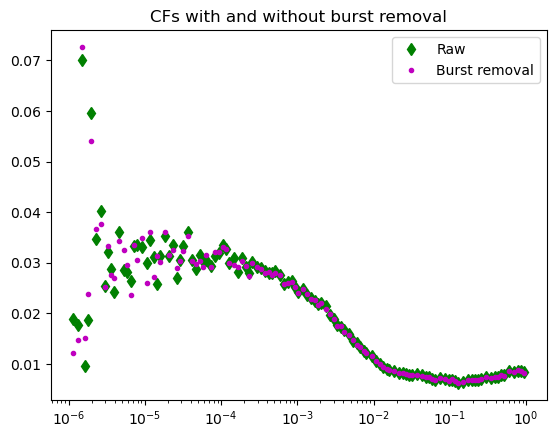

In [7]:
multi_channel_handling = 'OR' # 'OR', 'AND', or 'SUM'
threshold_alpha = 0.05
update_macro_times = True

default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10


if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    time_traces = np.concatenate((time_trace_counts_1.reshape((time_trace_counts_1.shape[0], 1)), time_trace_counts_2.reshape((time_trace_counts_2.shape[0], 1))), axis = 1) 
else:
    # The reshape is not really needed, we rather do it here for consistency of format. 
    time_traces = time_trace_counts_1.reshape((time_trace_counts_1.shape[0], 1))

burst_bins, photon_is_burst = fixer.run_burst_removal(time_traces,
                                                      time_trace_sampling,
                                                      multi_channel_handling = multi_channel_handling,
                                                      threshold_alpha = threshold_alpha,
                                                      threshold_counts = None,
                                                      update_weights = update_macro_times,
                                                      update_macro_times = True,
                                                      suppress_logging = False,
                                                      calling_function = script_name)

lags_br, cc_br, sd_cc_br, acr1_br, acr2_br = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                               channels_spec_2, 
                                                                               default_uncertainty_method = default_uncertainty_method,
                                                                               minimum_window_length = minimum_window_length,
                                                                               n_bootstrap_reps = n_bootstrap_reps,
                                                                               tau_min = None,
                                                                               tau_max = None,
                                                                               use_ext_weights = False, 
                                                                               use_drift_correction = False,
                                                                               use_flcs_bg_corr = False,
                                                                               use_burst_removal = True,
                                                                               use_mse_filter = False,
                                                                               suppress_logging = False,
                                                                               calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags*1E-9, cc, 'dg', label = 'Raw')
ax.semilogx(lags_br*1E-9, cc_br, '.m', label = 'Burst removal')
ax.set_title('CFs with and without burst removal')
ax.legend()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Artifact fix 2: Bleaching/drift, step 1: Recalculate time trace

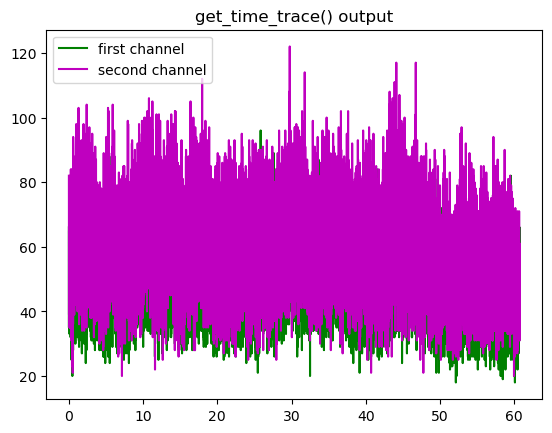

In [8]:
min_avg_counts = 10.
min_bin_width = 1E-4
use_tau_diff = True

time_trace_sampling = fixer.get_trace_time_scale(channels_spec_1,
                                                 min_avg_counts = min_avg_counts,
                                                 min_bin_width = min_bin_width,
                                                 use_tau_diff = use_tau_diff,
                                                 ext_indices = np.array([]),
                                                 use_ext_weights = False,
                                                 use_drift_correction = False,
                                                 use_flcs_bg_corr = False,
                                                 use_burst_removal = True,
                                                 use_mse_filter = False,
                                                 suppress_logging = False,
                                                 calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    # If we have two-channel data, let's use a geometric mean of 
    # time_trace_sampling suggestions for two the two channels as compromise
    time_trace_sampling = np.sqrt(time_trace_sampling * fixer.get_trace_time_scale(channels_spec_2,
                                                                                   min_avg_counts = min_avg_counts,
                                                                                   min_bin_width = min_bin_width,
                                                                                   use_tau_diff = use_tau_diff,
                                                                                   ext_indices = np.array([]),
                                                                                   use_ext_weights = False,
                                                                                   use_drift_correction = False,
                                                                                   use_flcs_bg_corr = False,
                                                                                   use_burst_removal = True,
                                                                                   use_mse_filter = False,
                                                                                   suppress_logging = False,
                                                                                   calling_function = script_name))

time_trace_counts_br_1, time_trace_t_br_1 = fixer.get_time_trace(channels_spec_1,
                                                                 time_trace_sampling,
                                                                 ext_indices = np.array([]),
                                                                 use_ext_weights = False,
                                                                 use_drift_correction = False,
                                                                 use_flcs_bg_corr = False,
                                                                 use_burst_removal = True,
                                                                 use_mse_filter = False,
                                                                 suppress_logging = False,
                                                                 calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    time_trace_counts_br_2, time_trace_t_br_2 = fixer.get_time_trace(channels_spec_2,
                                                                     time_trace_sampling,
                                                                     ext_indices = np.array([]),
                                                                     use_ext_weights = False,
                                                                     use_drift_correction = False,
                                                                     use_flcs_bg_corr = False,
                                                                     use_burst_removal = True,
                                                                     use_mse_filter = False,
                                                                     suppress_logging = False,
                                                                     calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time_trace_t_br_1, time_trace_counts_br_1, 'g', label = 'first channel')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    ax.plot(time_trace_t_br_2, time_trace_counts_br_2, 'm', label = 'second channel')
    ax.legend()
    
ax.set_title('get_time_trace() output')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Drift/bleaching correction continued: Actual correction

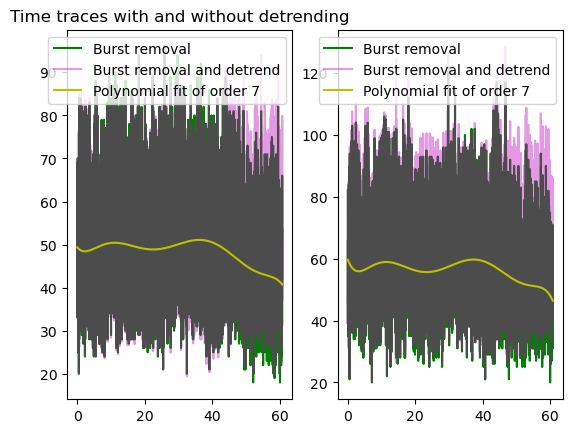

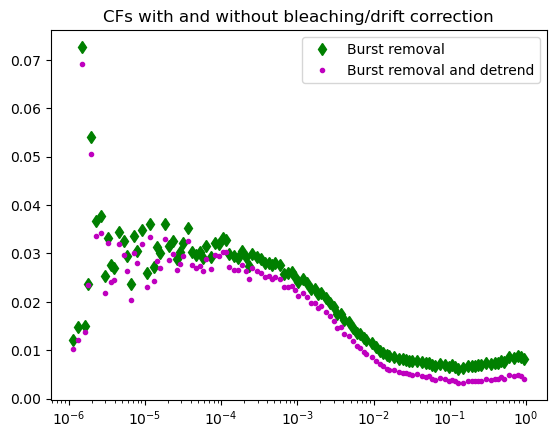

In [9]:
default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10


# Apply correction
poly_params_1 , time_trace_poly_1, time_trace_undrift_1 = fixer.polynomial_undrifting_rss(time_trace_counts_br_1, 
                                                                                          time_trace_t_br_1, 
                                                                                          channels_spec_1,
                                                                                          undrift_order = None,
                                                                                          max_undrift_order = 10,
                                                                                          update_undrift_weights = True,
                                                                                          ext_indices = np.array([]),
                                                                                          use_ext_weights = False,
                                                                                          use_flcs_bg_corr = False,
                                                                                          use_burst_removal = False,
                                                                                          use_mse_filter = False,
                                                                                          suppress_logging = False,
                                                                                          calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    poly_params_2 , time_trace_poly_2, time_trace_undrift_2 = fixer.polynomial_undrifting_rss(time_trace_counts_br_2, 
                                                                                              time_trace_t_br_2, 
                                                                                              channels_spec_2,
                                                                                              undrift_order = None,
                                                                                              max_undrift_order = 10,
                                                                                              update_undrift_weights = True,
                                                                                              ext_indices = np.array([]),
                                                                                              use_ext_weights = False,
                                                                                              use_flcs_bg_corr = False,
                                                                                              use_burst_removal = False,
                                                                                              use_mse_filter = False,
                                                                                              suppress_logging = False,
                                                                                              calling_function = script_name)

    # Plot pre and post correction time traces
    
    # Still in the statement for two distinct channels
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].plot(time_trace_t_br_1*1E-9, time_trace_counts_br_1, 'g', label = 'Burst removal')
    ax[0].plot(time_trace_t_br_1*1E-9, time_trace_undrift_1, 'm', alpha = 0.4, label = 'Burst removal and detrend')
    ax[0].plot(time_trace_t_br_1*1E-9, time_trace_poly_1, 'y', label = 'Polynomial fit of order '+ str(len(poly_params_1)-1))
    ax[1].plot(time_trace_t_br_2*1E-9, time_trace_counts_br_2, 'g', label = 'Burst removal')
    ax[1].plot(time_trace_t_br_2*1E-9, time_trace_undrift_2, 'm', alpha = 0.4, label = 'Burst removal and detrend')
    ax[1].plot(time_trace_t_br_2*1E-9, time_trace_poly_2, 'y', label = 'Polynomial fit of order '+ str(len(poly_params_2)-1))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Time traces with and without detrending')
    
else:
    # Plotting for single channel
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(time_trace_t_br_1*1E-9, time_trace_counts_br_1, 'g', label = 'Burst removal')
    ax.plot(time_trace_t_br_1*1E-9, time_trace_undrift_1, 'm', alpha = 0.4, label = 'Burst removal and detrend')
    ax.plot(time_trace_t_br_1*1E-9, time_trace_poly_1, 'y', label = 'Polynomial fit of order '+ str(len(poly_params_1)-1))
    ax.legend()
    ax.set_title('Time traces with and without detrending')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()
    
# Inspect correlation function
lags_br_dt, cc_br_dt, sd_cc_br_dt, acr1_br_dt, acr2_br_dt = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                                              channels_spec_2, 
                                                                                              default_uncertainty_method = default_uncertainty_method,
                                                                                              minimum_window_length = minimum_window_length,
                                                                                              n_bootstrap_reps = n_bootstrap_reps,
                                                                                              tau_min = None,
                                                                                              tau_max = None,
                                                                                              use_ext_weights = False, 
                                                                                              use_drift_correction = True,
                                                                                              use_flcs_bg_corr = False,
                                                                                              use_burst_removal = True,
                                                                                              use_mse_filter = False,
                                                                                              suppress_logging = False,
                                                                                              calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags_br*1E-9, cc_br, 'dg', label = 'Burst removal')
ax.semilogx(lags_br_dt*1E-9, cc_br_dt, '.m', label = 'Burst removal and detrend')
ax.set_title('CFs with and without bleaching/drift correction')
ax.legend()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Artifact fix 3: Remove segments with anomalous correlation functions

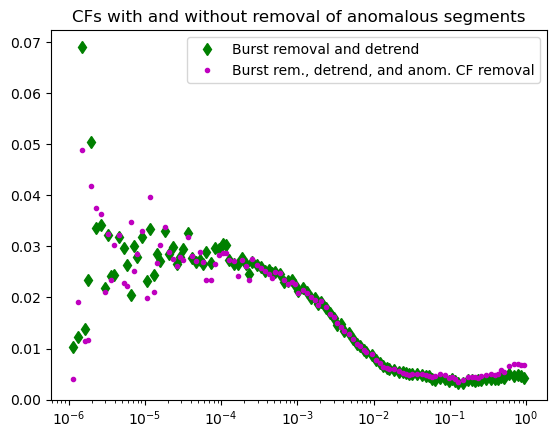

In [10]:
minimum_window_length = []
mse_fold_threshold = 2.5
update_macro_times = True
update_macro_times = True

mse_matrix, good_segments = fixer.run_mse_filter(channels_spec_1,
                                                 channels_spec_2,
                                                 minimum_window_length = minimum_window_length,
                                                 mse_fold_threshold = mse_fold_threshold,
                                                 ignore_amplitude_fluctuations = update_macro_times,
                                                 update_macro_times = update_macro_times,
                                                 update_weights = True,
                                                 tau_max = None,
                                                 tau_min = 1E5, # 100 us to cut off excessive noise
                                                 use_ext_weights = False, 
                                                 use_drift_correction = True, 
                                                 use_flcs_bg_corr = False,
                                                 use_burst_removal = True,
                                                 suppress_logging = False,
                                                 calling_function= script_name)

# Look at what that did to the correlation function
default_uncertainty_method = 'Wohland'
n_bootstrap_reps = 10

lags_br_dt_ar, cc_br_dt_ar, sd_cc_br_dt_ar, acr1_br_dt_ar, acr2_br_dt_ar = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                                                             channels_spec_2, 
                                                                                                             default_uncertainty_method = default_uncertainty_method,
                                                                                                             minimum_window_length = minimum_window_length,
                                                                                                             n_bootstrap_reps = n_bootstrap_reps,
                                                                                                             tau_min = None,
                                                                                                             tau_max = None,
                                                                                                             use_ext_weights = False, 
                                                                                                             use_drift_correction = True,
                                                                                                             use_flcs_bg_corr = False,
                                                                                                             use_burst_removal = True,
                                                                                                             use_mse_filter = True,
                                                                                                             suppress_logging = False,
                                                                                                             calling_function = script_name)
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags_br_dt*1E-9, cc_br_dt, 'dg', label = 'Burst removal and detrend')
ax.semilogx(lags_br_dt_ar*1E-9, cc_br_dt_ar, '.m', label = 'Burst rem., detrend, and anom. CF removal')
ax.set_title('CFs with and without removal of anomalous segments')
ax.legend()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()
    

### Artifact fix 4: Background (and afterpulsing) correction via FLCS, step 1: Background fitting

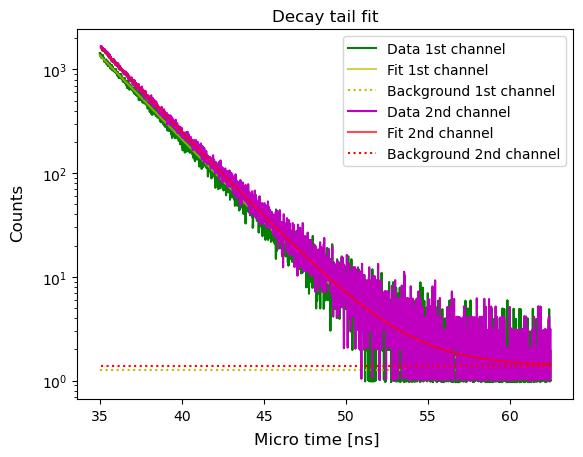

In [11]:
tcspc_x_1, tcspc_y_1 = fixer.get_tcspc_histogram(channels_spec_1,
                                                 ext_indices = np.array([]),
                                                 use_ext_weights = False,
                                                 use_drift_correction = True,
                                                 use_burst_removal = True,
                                                 use_mse_filter = True,
                                                 suppress_logging = False,
                                                 calling_function = script_name)

peak_position = np.argmax(tcspc_y_1) + tcspc_x_1[0]
fit_start = np.uint64(peak_position + np.ceil(2E-9 / fixer.micro_time_resolution)) # 1E-9 refers to 2 ns distance from peak here

flat_background_1, tail_fit_1 = fixer.get_background_tail_fit(channels_spec_1,
                                                                irf_peak_center = peak_position,
                                                                fit_start = fit_start,
                                                                ext_indices = np.array([]),
                                                                use_ext_weights = False,
                                                                use_drift_correction = True,
                                                                use_burst_removal = True,
                                                                use_mse_filter = True,
                                                                suppress_logging = False,
                                                                calling_function = script_name)
# The output variable tail_fit_1 is a TCSPC_quick_fit class instance, which you can inspect further if you like.

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogy(tail_fit_1.x * fixer.micro_time_resolution * 1E9,
            tail_fit_1.y, 'g', label='Data 1st channel')
ax.semilogy(tail_fit_1.x * fixer.micro_time_resolution * 1E9,
            tail_fit_1.prediction, 'y', alpha = 0.7, label='Fit 1st channel')
ax.semilogy(np.array([tail_fit_1.x[0], tail_fit_1.x[-1]]) * fixer.micro_time_resolution * 1E9,
            [flat_background_1, flat_background_1], ':y', label='Background 1st channel')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    tcspc_x_2, tcspc_y_2 = fixer.get_tcspc_histogram(channels_spec_2,
                                                 ext_indices = np.array([]),
                                                 use_ext_weights = False,
                                                 use_drift_correction = True,
                                                 use_burst_removal = True,
                                                 use_mse_filter = True,
                                                 suppress_logging = False,
                                                 calling_function = script_name)
        
    peak_position = np.argmax(tcspc_y_2) + tcspc_x_1[0]
    fit_start = np.uint64(peak_position + np.ceil(2E-9 / fixer.micro_time_resolution)) # 1E-9 refers to 2 ns distance from peak here

    flat_background_2, tail_fit_2 = fixer.get_background_tail_fit(channels_spec_2,
                                                                    irf_peak_center = peak_position,
                                                                    fit_start = fit_start,
                                                                    ext_indices = np.array([]),
                                                                    use_ext_weights = False,
                                                                    use_drift_correction = True,
                                                                    use_burst_removal = True,
                                                                    use_mse_filter = True,
                                                                    suppress_logging = False,
                                                                    calling_function = script_name)

    ax.semilogy(tail_fit_2.x * fixer.micro_time_resolution * 1E9,
                tail_fit_2.y, 'm', label='Data 2nd channel')
    ax.semilogy(tail_fit_2.x * fixer.micro_time_resolution * 1E9,
                tail_fit_2.prediction, 'r', alpha = 0.7, label='Fit 2nd channel')
    ax.semilogy(np.array([tail_fit_2.x[0], tail_fit_2.x[-1]]) * fixer.micro_time_resolution * 1E9,
                [flat_background_2, flat_background_2], ':r', label='Background 2nd channel')

    ax.legend()

fig.supxlabel('Micro time [ns]')
fig.supylabel('Counts')
ax.set_title('Decay tail fit')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Continuing FLCS correction: Get filter functions and correct correlation function

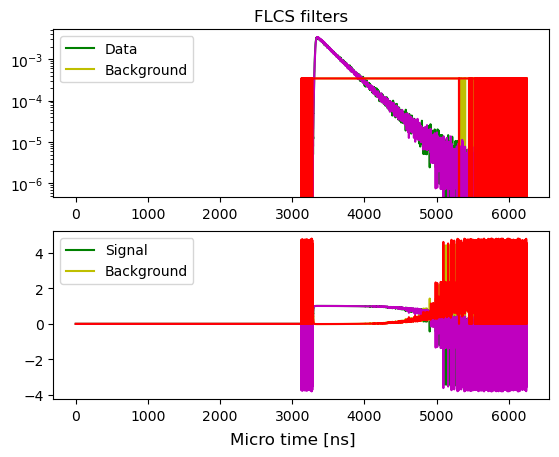

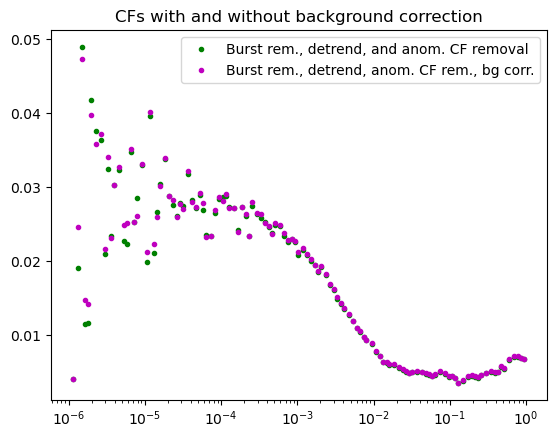

In [12]:
default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10

patterns_norm_full_1, flcs_weights_full_1 = fixer.get_flcs_background_filter(tcspc_x_1,
                                                                             tcspc_y_1,
                                                                             flat_background_1,
                                                                             channels_spec_1,
                                                                             handle_outside = 'zero',
                                                                             update_weights = True,
                                                                             ext_indices = np.array([]),
                                                                             suppress_logging = False,
                                                                             calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].semilogy(np.arange(patterns_norm_full_1.shape[0]), patterns_norm_full_1[:,0], 'g', label='Data')
ax[0].semilogy(np.arange(patterns_norm_full_1.shape[0]), patterns_norm_full_1[:,1], 'y', label='Background')

ax[1].plot(np.arange(patterns_norm_full_1.shape[0]), flcs_weights_full_1[:,0], 'g', label = 'Signal')
ax[1].plot(np.arange(patterns_norm_full_1.shape[0]), flcs_weights_full_1[:,1], 'y', label = 'Background')

ax[0].legend()
ax[1].legend()

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    patterns_norm_full_2, flcs_weights_full_2 = fixer.get_flcs_background_filter(tcspc_x_2,
                                                                                 tcspc_y_2,
                                                                                 flat_background_2,
                                                                                 channels_spec_2,
                                                                                 handle_outside = 'zero',
                                                                                 update_weights = True,
                                                                                 ext_indices = np.array([]),
                                                                                 suppress_logging = False,
                                                                                 calling_function = script_name)
    
    ax[0].semilogy(np.arange(patterns_norm_full_2.shape[0]), patterns_norm_full_2[:,0], 'm')
    ax[0].semilogy(np.arange(patterns_norm_full_2.shape[0]), patterns_norm_full_2[:,1], 'r')

    ax[1].plot(np.arange(patterns_norm_full_2.shape[0]), flcs_weights_full_2[:,0], 'm')
    ax[1].plot(np.arange(patterns_norm_full_2.shape[0]), flcs_weights_full_2[:,1], 'r')

fig.supxlabel('Micro time [ns]')
ax[0].set_title('FLCS filters')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()
    
    
lags_br_dt_ar_bg, cc_br_dt_ar_bg, sd_cc_br_dt_ar_bg, acr1_br_dt_ar_bg, acr2_br_dt_ar_bg = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                                                                            channels_spec_2, 
                                                                                                                            default_uncertainty_method = default_uncertainty_method,
                                                                                                                            minimum_window_length = minimum_window_length,
                                                                                                                            n_bootstrap_reps = n_bootstrap_reps,
                                                                                                                            tau_min = None,
                                                                                                                            tau_max = None,
                                                                                                                            use_ext_weights = False, 
                                                                                                                            use_drift_correction = True,
                                                                                                                            use_flcs_bg_corr = True,
                                                                                                                            use_burst_removal = True,
                                                                                                                            use_mse_filter = True,
                                                                                                                            suppress_logging = False,
                                                                                                                            calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags_br_dt_ar*1E-9, cc_br_dt_ar, '.g', label = 'Burst rem., detrend, and anom. CF removal')
ax.semilogx(lags_br_dt_ar_bg*1E-9, cc_br_dt_ar_bg, '.m', label = 'Burst rem., detrend, anom. CF rem., bg corr.')
ax.set_title('CFs with and without background correction')
ax.legend()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()
